In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
from sympy.physics.units import hour, Unit

In [3]:
sp.init_printing()

# Symbols

* Assume two capitalist running two companies A, B.
* The **labor time (labor value)** in company x is $X_x$ measured in hours per unit of production.
* The **wage (labor power)** for the employees at company x is $Y_x$ measured in dollars per hour.
* The **non wage expenses (constant capital)** of company x is $I_x$ measured in dollars per unit of production.
* The **selling price (exchange value)** for the final product in company x is $Z_x$ measured in dollars per unit of production.
* The **profit** for company x is $K_x$ measured in dollars per unit of production
* Assume A produces a machine which when bought by B has a **labor saving power (use value)** of $\Delta{X_B}$ hours per unit of production B. There is only one machine in the world at a time (this prevents needing to calculate the labor savings of N machines). One machine can produce P units of production B in its lifetime.

In [16]:
dollar = Unit("\$")
unit = sp.Symbol("unit_B")
dollar, unit

In [21]:
from collections import namedtuple
from functools import cache


@cache
def delta(x: sp.Symbol, units: sp.Expr):
    symbol_itself = x / units
    new_symbol = sp.Symbol(f"\Delta{{{symbol_itself}}}")
    return new_symbol * units


Company = namedtuple(
    "Company",
    [
        "labor_time",
        "wage",
        "selling_price",
        "non_wage_expenses",
        "profit",
    ],
)


@cache
def company(x: str) -> Company:
    Xx, Yx, Zx, Ix, Kx = sp.symbols(f"X_{x}, Y_{x}, Z_{x}, I_{x}, K_{x}")
    unit_ = 1 if x == "A" else unit
    labor_time = Xx * hour / unit_
    wage = Yx * dollar / hour
    selling_price = Zx * dollar / unit_
    non_wage_expenses = Ix * dollar / unit_
    profit = Kx * dollar / unit_
    return Company(
        labor_time,
        wage,
        selling_price,
        non_wage_expenses,
        profit,
    )

In [23]:
tuple(company("A"))

In [24]:
tuple(company("B"))

# Definitions

1. The cost of production per unit for company x == labor cost per unit + other cost per unit

In [25]:
def total_cost_of_production(x: str):
    comp = company(x)
    return comp.wage * comp.labor_time + comp.non_wage_expenses


total_cost_of_production("A"), total_cost_of_production("B")

2. The profit to the capitalist is the difference in the selling price and the total cost of expenses

In [26]:
def profit_perspective_of_point_of_sale(x: str):
    comp = company(x)
    return sp.Eq(comp.profit, comp.selling_price - total_cost_of_production(x))


profit_perspective_of_point_of_sale("A"), profit_perspective_of_point_of_sale("B")

3. The difference between the non wage cost of production for company B before the machine and the non wage cost of production after the machine is equal to the cost of the machine (sold by company A)

In [32]:
delta_non_wage_expenses_B = sp.Eq(
    delta(company("B").non_wage_expenses, units=dollar / unit),
    company("A").selling_price / (sp.Symbol("P") * unit),
)
delta_non_wage_expenses_B

# Assumptions

1. Under marx's LtV, the exchange value of a good equals its labor value times some conversion factor $\lambda$ measured in dollars per hour.

In [33]:
lam = sp.Symbol("\lambda") * dollar / hour


def LtV(x: str):
    comp = company(x)
    return sp.Eq(comp.selling_price, comp.labor_time * lam)


LtV("x")

2. Under max's theory of surplus value, profit is labor value (labor time converted into exchange value) minus labor power (wage)

In [34]:
def profit_perspective_of_surplus_value(x: str):
    comp = company(x)
    return sp.Eq(
        comp.profit, sp.simplify(comp.labor_time * lam - comp.wage * comp.labor_time)
    )


profit_perspective_of_surplus_value("x")

# Methodology

Because we are really talking about the change in profit, change in labor, etc, this will only be solved with differentials.

In [36]:
def delta_total_cost_of_production(x: str):
    # Relative to change in non-wage expenses
    comp = company(x)
    return delta(comp.non_wage_expenses, units=dollar / unit)


delta_total_cost_of_production("x")

In [37]:
def delta_profit_perspective_of_point_of_sale(x: str):
    # Relative to change in non-wage expenses
    comp = company(x)
    return sp.Eq(
        delta(comp.profit, units=dollar / unit),
        -delta_total_cost_of_production(x),
    )


delta_profit_perspective_of_point_of_sale("B")

Substitute out that $\Delta{I_B}$ using Equality #3

In [38]:
B = company("B")
delta_profit_perspective_of_point_of_sale_B_sub = sp.Eq(
    delta_profit_perspective_of_point_of_sale("B").lhs,
    delta_profit_perspective_of_point_of_sale("B").rhs.subs(
        delta_non_wage_expenses_B.lhs / dollar * unit,
        delta_non_wage_expenses_B.rhs / dollar * unit,
    ),
)
delta_profit_perspective_of_point_of_sale_B_sub

In [40]:
def delta_profit_perspective_of_surplus_value(x: str):
    # Relative to change in labor time
    comp = company(x)
    return sp.Eq(
        delta(comp.profit, units=dollar / unit),
        sp.expand(
            delta(comp.labor_time, units=hour / unit) * lam
            - comp.wage * delta(comp.labor_time, units=hour / unit)
        ),
    )


delta_profit_perspective_of_surplus_value_B = delta_profit_perspective_of_surplus_value(
    "B"
)
delta_profit_perspective_of_surplus_value_B

Take the difference of the right hand side of both.

Because we did these differentials differently, taking their difference will relate them by what varies between them.

In this case we are specifically interested in relating the change in non-wage expenses to the change in labor time, from the perspective of the marxist theory of value.

In [41]:
zero_eq = sp.Eq(
    delta_profit_perspective_of_surplus_value_B.lhs
    - delta_profit_perspective_of_point_of_sale_B_sub.lhs,
    delta_profit_perspective_of_surplus_value_B.rhs
    - delta_profit_perspective_of_point_of_sale_B_sub.rhs,
)
zero_eq

One way to interpret this is that $\lambda$ (which is a highly speculative variable assuming all labor has a fixed exchange value per unit time) is equal to the difference between the wage and the ratio of the price of the machine to the labor saving power of the machine.

In [42]:
sp.Eq(lam / (dollar / hour), sp.expand(sp.solve(zero_eq.rhs, lam / (dollar / hour))[0]))

Another way of looking at this is to say that the marxist definition of profit being extraction of surplus value from the worker is only true when this equality is true:

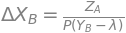

In [66]:
delta_x_b = sp.Eq(
    delta(company("B").labor_time, units=hour / unit) * unit / hour,
    sp.solve(zero_eq, delta(company("B").labor_time, units=hour / unit) * unit / hour)[
        0
    ],
)
delta_x_b

This says the marxist definition of profit will be true iff the difference in the labor saving hours of the machine is equal to the ratio of the cost of the machine per unit of production and the difference between wages and real value of labor.

So:

* If you increase the difference between the wage and the true value of labor, then the labor saving power of the machine is able to be less, because you can extract more profit from the workers to make up for the cost of the machine.
* If you decrease the difference between the wage and the true value of labor, then the labor saving power of the machine is has to be more, because you can only extract so much profit from the workers to make up for the cost of the machine.
* If you increase the cost of the machine, then the labor saving power of the machine needs to be more to cancel out the cost.
* If you decrease the cost of the machine, then the labor saving power of the machine needs to be less to cancel out the cost.
* If you increase the lifespan of the machine in units produced, then the labor saving power of the machine does not need to be as high per unit of production to cancel out the cost.
* If you decrease the lifespan of the machine in units produced, then the labor saving power of the machine needs to be higher per unit of production to cancel out the cost.

Other Research Questions:
* $\lambda$ could be loosened a bit to have a different conversion factor for each company. Different areas of work could have different "value". See what falls out of that model vs the current one.
* What is the difference between `use-value - labor-value` as a factor of exploitation vs the more traditional marxist exploitation quantity of labor-value - labor-power? What if I used the product to do as the other capitalist does instead of selling it to them? Would that fit under roemer's exploitation theory?

That seems perfectly reasonable. So given the assumptions are true, the surplus value theory of profix is compatible with the capitalist definition of profit.